In [2]:
# set to True if in colab
in_colab = False
last_data_idx = -1

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import tensorflow as tf
if in_colab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

In [5]:
if in_colab:
    import sys
    data_dir = "/content/drive/MyDrive/data/"
    VOC2012_path = data_dir
    tracker_path = data_dir
    sys.path.append(tracker_path)
    ssd_weights_path = data_dir + "ssd_weights_epoch_0380.h5"
    video_path = data_dir + "person_dog.mp4"
    out_path = data_dir + "person_dog_style_transfer.gif"
else:
    data_dir = "../data/"
    VOC2012_path = data_dir + "VOCdevkit/"
    tracker_path = "../Tracking_SSD_ReID/"
    ssd_weights_path = data_dir + "ssd_weights_epoch_0380.h5"
    video_path = "../data/video/person_dog.mp4"
    out_path = "../data/video/person_dog_style_transfer_test.gif"
    style_image_path = "imgs/style.jpg"

In [11]:
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
import imageio
from tqdm import tqdm
import cv2
from utils.eval import *

## Load model

In [7]:
from models.VGG16StyleTransfer import VGG16StyleTransfer
model = VGG16StyleTransfer(
    tracker_ssd_path = tracker_path, 
    ssd_weights_path = ssd_weights_path)

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=7)

## Infer on single image

In [43]:
style_image_path = "imgs/style_1.jpg"
content_image_path = "imgs/content.jpg"
out_path = "imgs/style_transfer_1.jpg"

In [42]:
model.inferOnImage(style_image_path, optimizer, 10,
                   content_image_path, out_path, resize=None,
                   add_content_img=False, add_style_img=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.55it/s]


In [ ]:
path_1 = content_image_path
path_2 = "imgs/style_transfer_1.jpg"
path_3 = "imgs/style_transfer_1.jpg"
path_4 = "imgs/style_transfer_1.jpg"
out_path = "imgs/concatenate_2.gif"
concat4Images(path_1, path_2, path_3, path_4, out_path)

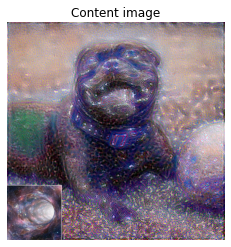

In [44]:
transfer_style_result = Image.open(out_path)
transfer_style_result = np.array(transfer_style_result)

plt.axis('off')
plt.title("Content image")
plt.imshow(transfer_style_result)

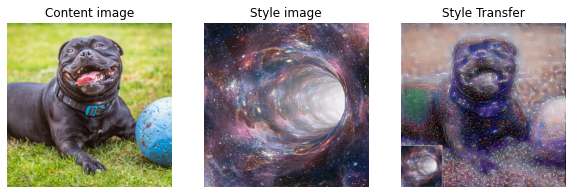

In [24]:
style_image = Image.open(style_image_path)
style_image = np.array(style_image)

content_image = Image.open(content_image_path)
content_image = np.array(content_image)

fig, axs = plt.subplots(1, 3, figsize=(10, 15), facecolor='w', edgecolor='k')

axs[0].axis('off')
axs[0].set_title("Content image")
axs[0].imshow(content_image)

axs[1].axis('off')
axs[1].set_title("Style image")
axs[1].imshow(style_image)

axs[2].axis('off')
axs[2].set_title("Style Transfer")
axs[2].imshow(transfer_style_result)

In [14]:
fig.savefig('imgs/style_transfer.png', dpi=75, bbox_inches = 'tight', pad_inches = 0.5)

## Infer on video

In [10]:
model.inferOnVideo(style_image, optimizer, 2, video_path, out_path,
                   start_idx=60, end_idx=62, skip=2, resize=(500,234), fps=22, add_style_img=False, add_content_img=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 31.03it/s]


In [1]:
path_1 = "../data/video/person_dog_content.gif"
path_2 = "../data/video/person_dog_style_transfer_1.gif"
path_3 = "../data/video/person_dog_style_transfer_2.gif"
path_4 = "../data/video/person_dog_style_transfer_4.gif"
out_path = "imgs/concatenate_2.gif"
concat4Gif(path_1, path_2, path_3, path_4, out_path)

100%|████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 1377.09it/s]
